# Import library

In [1]:
import os
import os.path as osp
import math
import time
import glob
import abc
from config import cfg
from utils.vis import vis_keypoints, vis_3d_skeleton
import cv2
import numpy as np
from dataset import DatasetLoader
from dataloader import DataLoader
from multiple_datasets import MultipleDatasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# dynamic dataset import
for i in range(len(cfg.trainset_3d)):
    exec('from ' + cfg.trainset_3d[i] + ' import ' + cfg.trainset_3d[i])
for i in range(len(cfg.trainset_2d)):
    exec('from ' + cfg.trainset_2d[i] + ' import ' + cfg.trainset_2d[i])
exec('from ' + cfg.testset + ' import ' + cfg.testset)

# load dataset

#### train dataset

In [3]:
trainset3d_loader = []
for i in range(len(cfg.trainset_3d)):
    if i > 0:
        ref_joints_name = trainset3d_loader[0].joints_name
    else:
        ref_joints_name = None
    trainset3d_loader.append(DatasetLoader(eval(cfg.trainset_3d[i])("train"), ref_joints_name, True))

ref_joints_name = trainset3d_loader[0].joints_name
trainset2d_loader = []
for i in range(len(cfg.trainset_2d)):
    trainset2d_loader.append(DatasetLoader(eval(cfg.trainset_2d[i])("train"), ref_joints_name, True))

joint_num = trainset3d_loader[0].joint_num

trainset3d_loader = MultipleDatasets(trainset3d_loader, make_same_len=False)
trainset2d_loader = MultipleDatasets(trainset2d_loader, make_same_len=False)
trainset_loader = MultipleDatasets([trainset3d_loader, trainset2d_loader], make_same_len=True)

itr_per_epoch = math.ceil(len(trainset_loader) / cfg.num_gpus / cfg.batch_size)

Load data of H36M Protocol 2
creating index...
index created!
Get bounding box and root from groundtruth
loading annotations into memory...
Done (t=29.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=3.19s)
creating index...
index created!


#### test dataset

In [4]:
testset = eval(cfg.testset)("test")
testset_loader = DatasetLoader(testset, None, False)

Load data of H36M Protocol 2
creating index...
index created!
Get bounding box and root from groundtruth


### load sample data

In [15]:
input_img, joint_img, joint_vis, joints_have_depth = trainset_loader[0]

In [16]:
input_img.shape

(256, 256, 3)

### visualize

In [17]:
tmpimg = input_img
tmpimg = tmpimg * np.array(cfg.pixel_std).reshape(1,1,3) + np.array(cfg.pixel_mean).reshape(1,1,3)
tmpimg = tmpimg.astype(np.uint8)

In [18]:
tmpimg

array([[[228, 245, 255],
        [228, 247, 255],
        [228, 247, 255],
        ...,
        [203, 176, 175],
        [203, 176, 173],
        [200, 173, 169]],

       [[228, 245, 255],
        [228, 247, 255],
        [228, 247, 255],
        ...,
        [204, 178, 177],
        [203, 176, 173],
        [201, 174, 170]],

       [[228, 245, 255],
        [228, 247, 255],
        [228, 247, 255],
        ...,
        [200, 174, 173],
        [199, 172, 168],
        [199, 172, 168]],

       ...,

       [[ 63, 182, 227],
        [ 86,  91, 184],
        [134, 134, 227],
        ...,
        [ 72,  26,  28],
        [ 73,  27,  29],
        [ 73,  28,  30]],

       [[143, 158, 189],
        [ 82,  60,  56],
        [ 67, 159, 140],
        ...,
        [ 72,  26,  28],
        [ 71,  25,  27],
        [ 71,  25,  27]],

       [[ 53, 152, 127],
        [105,  40,  99],
        [100, 142, 173],
        ...,
        [ 72,  26,  28],
        [ 71,  25,  27],
        [ 71,  25,  27]]

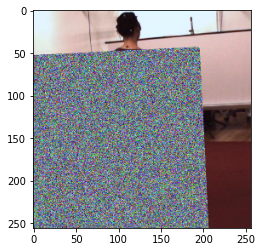

In [19]:
plt.imshow(tmpimg)

In [20]:
skeleton = ( (0, 7), (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), (8, 14), (14, 15), (15, 16), (0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6) )

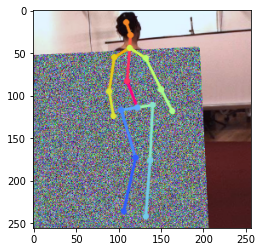

In [21]:
tmpkps = np.zeros((3,joint_num))
tmpkps[:2,:] = joint_img[:,:2].transpose(1,0) / cfg.output_shape[0] * cfg.input_shape[0]
tmpkps[2,:] = joint_vis[:,0]
tmpimg = vis_keypoints(tmpimg, tmpkps, skeleton)
plt.imshow(tmpimg)

### load dataloader

#### train dataloader

In [22]:
len(trainset_loader)

1590104

In [23]:
batch_generator = DataLoader(dataset=trainset_loader, batch_size=cfg.num_gpus*cfg.batch_size, shuffle=False, is_train=True)

In [24]:
len(batch_generator) # 1590104 / 4

397526

In [25]:
batch_data = batch_generator[0]

/workspace/Developments/CECD/pose3d/main/../data/dataloader.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_data = np.array([self.dataset[i] for i in indices])


In [26]:
input_img, joint_img, joint_vis, joints_have_depth = batch_data

In [27]:
input_img.shape, joint_img.shape, joint_vis.shape, joints_have_depth.shape

((4, 256, 256, 3), (4, 18, 3), (4, 18, 1), (4, 1))

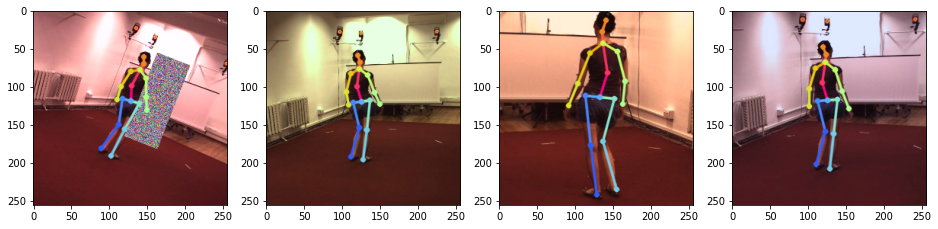

In [28]:
skeleton = ( (0, 7), (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), (8, 14), (14, 15), (15, 16), (0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6) )
plt.figure(figsize=(16, 4*(int(np.floor(cfg.batch_size/4)))))
row, col = (int(np.floor(cfg.batch_size/4)), 4)

for i in range(cfg.batch_size):
    tmpimg = input_img[i]
    tmpimg = tmpimg * np.array(cfg.pixel_std).reshape(1,1,3) + np.array(cfg.pixel_mean).reshape(1,1,3)
    tmpimg = tmpimg.astype(np.uint8)
    tmpkps = np.zeros((3,joint_num))
    tmpkps[:2,:] = joint_img[i, :,:2].transpose(1,0) / cfg.output_shape[0] * cfg.input_shape[0]
    tmpkps[2,:] = joint_vis[i, :,0]
    tmpimg = vis_keypoints(tmpimg, tmpkps, skeleton)
    plt.subplot(row, col, i+1)
    plt.imshow(tmpimg)

#### test dataloader

In [38]:
test_batch_generator = DataLoader(dataset=testset_loader, batch_size=cfg.num_gpus*cfg.batch_size, shuffle=True)

In [39]:
test_batch_data = test_batch_generator[0]

In [40]:
test_batch_data.shape

(4, 256, 256, 3)

In [43]:
input_img = test_batch_data

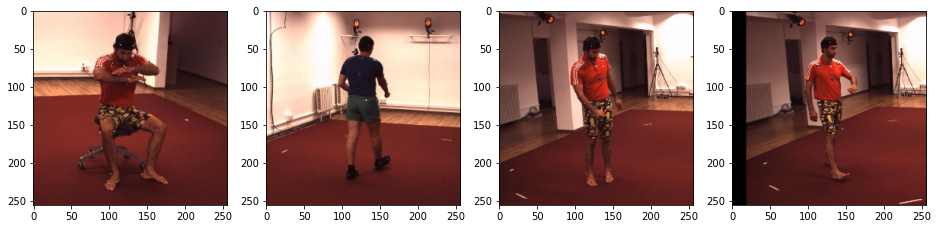

In [44]:
skeleton = ( (0, 7), (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), (8, 14), (14, 15), (15, 16), (0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6) )
plt.figure(figsize=(16, 4*(int(np.floor(cfg.batch_size/4)))))
row, col = (int(np.floor(cfg.batch_size/4)), 4)

for i in range(cfg.batch_size):
    tmpimg = input_img[i]
    tmpimg = tmpimg * np.array(cfg.pixel_std).reshape(1,1,3) + np.array(cfg.pixel_mean).reshape(1,1,3)
    tmpimg = tmpimg.astype(np.uint8)
    plt.subplot(row, col, i+1)
    plt.imshow(tmpimg)